# Purpose of this notebook:
- check the MAGIC-LST1 event coincidence between LST1 DL2 files and MAGIC Melibea files
- use the most updated event coincidence algorithm with fixed coincidence window (= 1 µs)
- check the event coincidence with LST1 subrun-wise algorithm

In [1]:
import re
import sys
import time
import glob
import pickle
import uproot
import warnings
import numpy as np 
import pandas as pd 
from astropy.time import Time
from matplotlib import pyplot, colors

In [2]:
pyplot.rcParams['figure.figsize'] = (8, 6)
pyplot.rcParams['font.size'] = 15
pyplot.rcParams['grid.linestyle'] = ':'

In [3]:
warnings.simplefilter('ignore')
colors_default = pyplot.rcParams['axes.prop_cycle'].by_key()['color']

# Load the MAGIC Melibea files

Get the path to the  data:

In [4]:
data_mask = '/fefs/aswg/workspace/yoshiki.ohtani/Data/LaPalma/MAGIC/CrabNebula/20200118/Melibea/*_0508850*.root'
data_paths_magic = glob.glob(data_mask)
data_paths_magic.sort()

In [5]:
data_paths_magic

['/fefs/aswg/workspace/yoshiki.ohtani/Data/LaPalma/MAGIC/CrabNebula/20200118/Melibea/20200118_05088502_Q_CrabNebula-W0.40+215.root',
 '/fefs/aswg/workspace/yoshiki.ohtani/Data/LaPalma/MAGIC/CrabNebula/20200118/Melibea/20200118_05088503_Q_CrabNebula-W0.40+035.root',
 '/fefs/aswg/workspace/yoshiki.ohtani/Data/LaPalma/MAGIC/CrabNebula/20200118/Melibea/20200118_05088504_Q_CrabNebula-W0.40+215.root',
 '/fefs/aswg/workspace/yoshiki.ohtani/Data/LaPalma/MAGIC/CrabNebula/20200118/Melibea/20200118_05088505_Q_CrabNebula-W0.40+035.root',
 '/fefs/aswg/workspace/yoshiki.ohtani/Data/LaPalma/MAGIC/CrabNebula/20200118/Melibea/20200118_05088506_Q_CrabNebula-W0.40+215.root']

Load the data and make a data frame:

In [6]:
# === function to convert the unit of MAGIC Length and Width from [mm] to [deg]
def mm2deg_magic(data):
    foclen = 16.969999 # [m]
    mm2m = 1e-3
    
    return np.rad2deg(np.arctan2(data*mm2m, foclen))

In [7]:
dl2_data_magic = pd.DataFrame()
cm2m = 1e-2
gev2tev = 1e-3

for data_path in data_paths_magic:
    
    with uproot.open(data_path) as input_data:
        
        for tel_id in [1, 2]:
            df = pd.DataFrame()
            
            # === event info ===
            df['event_id_magic'] = np.array(list(map(int, input_data['Events'][f'MRawEvtHeader_{tel_id}.fStereoEvtNumber'].array())))
            df['run_id_magic'] = np.repeat(input_data['RunHeaders'][f'MRawRunHeader_{tel_id}.fRunNumber'].array()[0], len(df))
            df['tel_id'] = np.repeat(tel_id, len(df))
            
            # === pointing parameters ===
            df['alt_tel'] = np.deg2rad(90 - input_data['Events'][f'MPointingPos_{tel_id}.fZd'].array())    # unit: [rad]
            df['az_tel'] = np.deg2rad(input_data['Events'][f'MPointingPos_{tel_id}.fAz'].array())     # unit: [rad]
            
            # === timing parameters ===
            df['mjd'] = input_data['Events'][f'MTime_{tel_id}.fMjd'].array()
            df['millisec'] = input_data['Events'][f'MTime_{tel_id}.fTime.fMilliSec'].array()    # unit: [millisec]
            df['nanosec'] = input_data['Events'][f'MTime_{tel_id}.fNanoSec'].array()    # unit: [nanosec]

            # === Hillas parameters ===
            df['intensity'] = input_data['Events'][f'MHillas_{tel_id}.fSize'].array()  # unit: [phe]
            df['length'] = mm2deg_magic(input_data['Events'][f'MHillas_{tel_id}.fLength'].array())    # unit: [deg]
            df['width'] = mm2deg_magic(input_data['Events'][f'MHillas_{tel_id}.fWidth'].array())    # unit: [deg]
            
            # === MAGIC RF-estimated parameters === 
            df['reco_az_magic'] = np.deg2rad(input_data['Events'][f'MStereoParDisp.fDirectionAz'].array())  # unit: [rad]
            df['reco_alt_magic'] = np.deg2rad(90 - input_data['Events'][f'MStereoParDisp.fDirectionZd'].array())  # unit: [rad]
            df['reco_energy_magic'] = input_data['Events']['MEnergyEst.fEnergy'].array()*gev2tev   # unit: [TeV]
            df['reco_impact_magic'] = input_data['Events'][f'MStereoParDisp.fM{tel_id}Impact'].array()*cm2m  # unit: [m]
            df['reco_core_x_magic'] = input_data['Events'][f'MStereoParDisp.fCoreX'].array()*cm2m  # unit: [m]
            df['reco_core_y_magic'] = input_data['Events'][f'MStereoParDisp.fCoreY'].array()*cm2m  # unit: [m]
            df['theta2_magic'] = input_data['Events']['MStereoParDisp.fTheta2'].array()  # unit: [deg^2] 
            df['hadronness_magic'] = input_data['Events']['MHadronness.fHadronness'].array()

            dl2_data_magic = dl2_data_magic.append(df)

Set the index to the data set:

In [8]:
dl2_data_magic.set_index(['run_id_magic', 'event_id_magic', 'tel_id'], inplace=True)
dl2_data_magic.sort_index(inplace=True)

Reconstruct the timestamps:

In [9]:
ms2sec = 1e-3
ns2sec = 1e-9
timestamps = {}

for tel_id in [1, 2]:
    # === calculate the MAGIC timestamps ===
    df = dl2_data_magic.query(f'tel_id == {tel_id}')
    day = Time(df['mjd'].values, format='mjd', scale='utc')
    timestamps[tel_id] = day.unix + df['millisec']*ms2sec + df['nanosec']*ns2sec
    del df
    
dl2_data_magic['timestamp'] = pd.concat([timestamps[1], timestamps[2]])
del timestamps

Check the contents of the data frame:

In [10]:
dl2_data_magic.columns

Index(['alt_tel', 'az_tel', 'mjd', 'millisec', 'nanosec', 'intensity',
       'length', 'width', 'reco_az_magic', 'reco_alt_magic',
       'reco_energy_magic', 'reco_impact_magic', 'reco_core_x_magic',
       'reco_core_y_magic', 'theta2_magic', 'hadronness_magic', 'timestamp'],
      dtype='object')

In [11]:
dl2_data_magic.head(4)

alt_tel    az_tel    mjd  millisec  \
run_id_magic event_id_magic tel_id                                        
5088502      2507           1       1.446440  2.921982  58866  -4085608   
                            2       1.446438  2.921965  58866  -4085608   
             2508           1       1.446440  2.921982  58866  -4085608   
                            2       1.446438  2.921965  58866  -4085608   

                                    nanosec   intensity    length     width  \
run_id_magic event_id_magic tel_id                                            
5088502      2507           1         54800  264.468750  0.560503  0.088699   
                            2         54800   97.468750  0.420976  0.058726   
             2508           1        129400   66.312500  0.087841  0.053840   
                            2        129400  128.414062  0.129082  0.057076   

                                    reco_az_magic  reco_alt_magic  \
run_id_magic event_id_magic tel_id                                  
5088502      2507           1                 NaN             NaN   
                            2                 NaN             NaN   
             2508           1                 NaN             NaN   
                            2                 NaN             NaN   

                                    reco_energy_magic  reco_impact_magic  \
run_id_magic event_id_magic tel_id                                         
5088502      2507           1                  -0.001              -0.01   
                            2                  -0.001              -0.01   
             2508           1                  -0.001              -0.01   
                            2                  -0.001              -0.01   

                                    reco_core_x_magic  reco_core_y_magic  \
run_id_magic event_id_magic tel_id                                         
5088502      2507           1                     NaN                NaN   
                            2                     NaN                NaN   
             2508           1                     NaN                NaN   
                            2                     NaN                NaN   

                                    theta2_magic  hadronness_magic  \
run_id_magic event_id_magic tel_id                                   
5088502      2507           1               -1.0          0.822413   
                            2               -1.0          0.822413   
             2508           1               -1.0          0.931667   
                            2               -1.0          0.931667   

                                       timestamp  
run_id_magic event_id_magic tel_id                
5088502      2507           1       1.579302e+09  
                            2       1.579302e+09  
             2508           1       1.579302e+09  
                            2       1.579302e+09

In [12]:
dl2_data_magic.tail(4)

alt_tel    az_tel    mjd  millisec  \
run_id_magic event_id_magic tel_id                                        
5088506      111120         1       1.225006  4.435052  58866   1234167   
                            2       1.225005  4.435053  58866   1234167   
             111121         1       1.225006  4.435052  58866   1234168   
                            2       1.225005  4.435053  58866   1234168   

                                    nanosec   intensity    length     width  \
run_id_magic event_id_magic tel_id                                            
5088506      111120         1         41400  110.343750  0.156022  0.042688   
                            2         41200  217.031250  0.360747  0.062696   
             111121         1          6800   60.421875  0.076312  0.039360   
                            2          6600  580.437500  0.364253  0.131171   

                                    reco_az_magic  reco_alt_magic  \
run_id_magic event_id_magic tel_id                                  
5088506      111120         1                 NaN             NaN   
                            2                 NaN             NaN   
             111121         1                 NaN             NaN   
                            2                 NaN             NaN   

                                    reco_energy_magic  reco_impact_magic  \
run_id_magic event_id_magic tel_id                                         
5088506      111120         1                  -0.001              -0.01   
                            2                  -0.001              -0.01   
             111121         1                  -0.001              -0.01   
                            2                  -0.001              -0.01   

                                    reco_core_x_magic  reco_core_y_magic  \
run_id_magic event_id_magic tel_id                                         
5088506      111120         1                     NaN                NaN   
                            2                     NaN                NaN   
             111121         1                     NaN                NaN   
                            2                     NaN                NaN   

                                    theta2_magic  hadronness_magic  \
run_id_magic event_id_magic tel_id                                   
5088506      111120         1               -1.0          0.897357   
                            2               -1.0          0.897357   
             111121         1               -1.0          0.990000   
                            2               -1.0          0.990000   

                                       timestamp  
run_id_magic event_id_magic tel_id                
5088506      111120         1       1.579307e+09  
                            2       1.579307e+09  
             111121         1       1.579307e+09  
                            2       1.579307e+09

In [13]:
for tel_id in [1, 2]:
    df = dl2_data_magic.query(f'tel_id == {tel_id}')
    print(f'MAGIC{tel_id}:  {len(df)} events')

MAGIC1:  943611 events
MAGIC2:  943611 events


# Check the Event coincidence

Define the path to the LST1 data:

In [24]:
data_path_lst = '/fefs/aswg/data/real/DL2/20200117/v0.5.2_v03/dl2_LST-1.Run01818.0000.h5'

Define the parameters used for the coincidence:

In [25]:
window = 1e-6   # unit: [sec]
bins_offset = np.arange(-5e-6, 0, 1e-7)   # unit: [sec]

In [26]:
params_base = ['intensity', 'length', 'width', 'alt_tel', 'az_tel', 'timestamp']
params_lst = ['reco_alt_lst', 'reco_az_lst', 'reco_energy_lst', 'hadronness_lst']
params_magic = ['reco_impact_magic', 'reco_core_x_magic', 'reco_core_y_magic', 'reco_alt_magic', 'reco_az_magic',
                                'reco_energy_magic', 'theta2_magic', 'hadronness_magic']

Check the event coincidence:

Loading the LST1 DL2 file...

Checking the coincidence...
0/39102
10000/39102
20000/39102
30000/39102
39101/39102

Optimized time-offset = -3.08 [µs]
Making the coincident event list with the optimized time-offset...

elapsed time = 18.43 [sec]
Done.


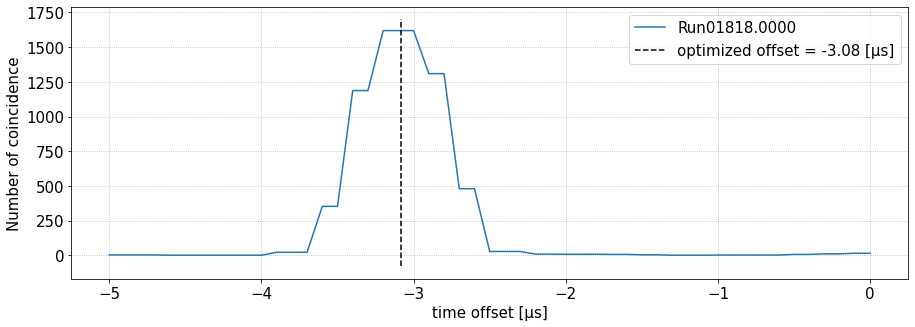

In [32]:
pyplot.figure(figsize=(15, 5))
pyplot.xlabel('time offset [µs]')
pyplot.ylabel('Number of coincidence')

start_time = time.time()
sec2us = 1e6

# === load the LST1 DL2 file ===
print('Loading the LST1 DL2 file...\n')

df_lst = pd.read_hdf(data_path_lst, key='dl2/event/telescope/parameters/LST_LSTCam')
n_events_lst = len(df_lst)

parse = re.findall('.*dl2_LST-1.Run(\d+).(\d+).h5', data_path_lst)[0]
run_id_lst = parse[0]
subrun_id_lst = parse[1]
df_lst['run_id_lst'] = np.repeat(run_id_lst, n_events_lst)
df_lst['subrun_id_lst'] = np.repeat(subrun_id_lst, n_events_lst)
df_lst.rename(columns={'event_id': 'event_id_lst'}, inplace=True)
df_lst.set_index(['run_id_lst', 'subrun_id_lst', 'event_id_lst', 'tel_id'], inplace=True)

ts_lst = df_lst['dragon_time'].values

# === extract the corresponding MAGIC events === 
df_magic = {1: dl2_data_magic.query('tel_id == 1'),
                       2: dl2_data_magic.query('tel_id == 2')}

condition = ( df_magic[1]['timestamp'].values > ts_lst[0] - window ) & (df_magic[1]['timestamp'].values < ts_lst[-1] + window)

if np.sum(condition) == 0:
    print('No MAGIC events within the LST data observation time window. Check your MAGIC and LST input files. Exiting.')
    pyplot.close()
    print('Done.')
    sys.exit()

df_magic[1] = df_magic[1].iloc[condition]
df_magic[2] = df_magic[2].iloc[condition]

ts_magic = df_magic[1]['timestamp'].values

# === check the overlap observation time === 
obs_time_lst = ts_lst[-1] - ts_lst[0]
obs_time_magic = ts_magic[-1] - ts_magic[0]

if obs_time_magic < obs_time_lst:
    obs_time = obs_time_magic
else:
    obs_time = obs_time_lst

# === check the event coincidence in each time offset === 
print('Checking the coincidence...')

n_stereo_list = np.zeros(len(bins_offset))

for i_ev in range(n_events_lst): 

    if i_ev%10000 == 0:
        print(f'{i_ev}/{n_events_lst}')
    
    for i_off, offset in enumerate(bins_offset): 
        
        ts_lim_lo = ts_lst[i_ev] - window/2 + offset
        ts_lim_hi = ts_lst[i_ev] + window/2 + offset
        
        condition_lo = ( ts_lim_lo <  ts_magic )
        condition_hi = ( ts_magic < ts_lim_hi )

        if np.count_nonzero(condition_lo&condition_hi) == 1:
            n_stereo_list[i_off] += 1

print(f'{i_ev}/{n_events_lst}\n')
            
# === optimize the time-offset === 
index_max = np.where(n_stereo_list == np.max(n_stereo_list))
offset_max = np.average(bins_offset[index_max])

indices = np.where((bins_offset >= offset_max - window) & (bins_offset <= offset_max + window))
offset_opt = np.average(bins_offset[indices], weights=n_stereo_list[indices])
print(f'Optimized time-offset = {offset_opt*sec2us:.2f} [µs]')

pyplot.plot(bins_offset*sec2us, n_stereo_list, label=f'Run{run_id_lst}.{subrun_id_lst}')
pyplot.plot((offset_opt*sec2us, offset_opt*sec2us), pyplot.ylim(), linestyle='--', color='black', 
                        label=f'optimized offset = {offset_opt*sec2us:.2f} [µs]')

# === recheck the event coincidence with optimized time offset === 
indices_magic = []
indices_lst = []
run_ids_lst = []
subrun_ids_lst = []
event_ids_lst = []

for i_ev in range(n_events_lst):

    ts_lst_lo = ts_lst[i_ev] - window/2 + offset_opt
    ts_lst_hi = ts_lst[i_ev] + window/2 + offset_opt

    lim_low = ( ts_lst_lo <  ts_magic )
    lim_high = ( ts_magic < ts_lst_hi )

    if np.count_nonzero(lim_low&lim_high) == 1:
        index_magic = np.where(lim_low&lim_high)[0][0]
        indices_magic.append(index_magic)
        indices_lst.append(i_ev)
        run_ids_lst.append(df_lst.iloc[i_ev].name[0])
        subrun_ids_lst.append(df_lst.iloc[i_ev].name[1])
        event_ids_lst.append(df_lst.iloc[i_ev].name[2])
        
# === make the coincident event list === 
print('Making the coincident event list with the optimized time-offset...\n')

df_lst = df_lst.iloc[indices_lst]
df_lst['hadronness_lst'] = 1 - df_lst['gammaness'].values
df_lst.rename(columns={'dragon_time': 'timestamp', 'reco_alt': 'reco_alt_lst', 
                                            'reco_az': 'reco_az_lst', 'reco_energy': 'reco_energy_lst'}, inplace=True)

df_lst = df_lst[params_base + params_lst]

for tel_id in [1, 2]:
    df_magic[tel_id] = df_magic[tel_id].iloc[indices_magic][params_base + params_magic]
    df_magic[tel_id]['run_id_lst'] = run_ids_lst
    df_magic[tel_id]['subrun_id_lst'] = subrun_ids_lst
    df_magic[tel_id]['event_id_lst'] = event_ids_lst
    df_magic[tel_id].reset_index(inplace=True)
    df_magic[tel_id]['tel_id'] = np.repeat(tel_id+4, len(df_magic[tel_id]))   # M1/2:  tel_id = 5, 6
    df_magic[tel_id].set_index(['run_id_lst', 'subrun_id_lst', 'event_id_lst', 'tel_id'], inplace=True)

dl2_data_stereo = pd.concat([df_lst, df_magic[1], df_magic[2]])
dl2_data_stereo = dl2_data_stereo.sort_index()   
dl2_data_stereo['obs_time'] = np.repeat(obs_time, len(dl2_data_stereo))
dl2_data_stereo['time_offset'] = np.repeat(offset_opt, len(dl2_data_stereo))

pyplot.legend()
pyplot.grid()

end_time = time.time()
print(f'elapsed time = {end_time - start_time:.2f} [sec]')

print('Done.')

Check the coincident event list:

In [34]:
dl2_data_stereo.columns

Index(['intensity', 'length', 'width', 'alt_tel', 'az_tel', 'timestamp',
       'reco_alt_lst', 'reco_az_lst', 'reco_energy_lst', 'hadronness_lst',
       'run_id_magic', 'event_id_magic', 'reco_impact_magic',
       'reco_core_x_magic', 'reco_core_y_magic', 'reco_alt_magic',
       'reco_az_magic', 'reco_energy_magic', 'theta2_magic',
       'hadronness_magic', 'obs_time', 'time_offset'],
      dtype='object')

In [35]:
dl2_data_stereo.head(3)

intensity    length     width  \
run_id_lst subrun_id_lst event_id_lst tel_id                                   
01818      0000          3            1        654.46523  0.320582  0.272988   
                                      5        173.12500  0.112769  0.097941   
                                      6       1002.31250  0.571612  0.233917   

                                               alt_tel    az_tel  \
run_id_lst subrun_id_lst event_id_lst tel_id                       
01818      0000          3            1       1.450127  3.363094   
                                      5       1.445390  3.398182   
                                      6       1.445386  3.398181   

                                                 timestamp  reco_alt_lst  \
run_id_lst subrun_id_lst event_id_lst tel_id                               
01818      0000          3            1       1.579302e+09      1.526906   
                                      5       1.579302e+09           NaN   
                                      6       1.579302e+09           NaN   

                                              reco_az_lst  reco_energy_lst  \
run_id_lst subrun_id_lst event_id_lst tel_id                                 
01818      0000          3            1          4.295089         1.426095   
                                      5               NaN              NaN   
                                      6               NaN              NaN   

                                              hadronness_lst  ...  \
run_id_lst subrun_id_lst event_id_lst tel_id                  ...   
01818      0000          3            1             0.983333  ...   
                                      5                  NaN  ...   
                                      6                  NaN  ...   

                                              reco_impact_magic  \
run_id_lst subrun_id_lst event_id_lst tel_id                      
01818      0000          3            1                     NaN   
                                      5                   -0.01   
                                      6                   -0.01   

                                              reco_core_x_magic  \
run_id_lst subrun_id_lst event_id_lst tel_id                      
01818      0000          3            1                     NaN   
                                      5                     NaN   
                                      6                     NaN   

                                              reco_core_y_magic  \
run_id_lst subrun_id_lst event_id_lst tel_id                      
01818      0000          3            1                     NaN   
                                      5                     NaN   
                                      6                     NaN   

                                              reco_alt_magic  reco_az_magic  \
run_id_lst subrun_id_lst event_id_lst tel_id                                  
01818      0000          3            1                  NaN            NaN   
                                      5                  NaN            NaN   
                                      6                  NaN            NaN   

                                              reco_energy_magic  theta2_magic  \
run_id_lst subrun_id_lst event_id_lst tel_id                                    
01818      0000          3            1                     NaN           NaN   
                                      5                  -0.001          -1.0   
                                      6                  -0.001          -1.0   

                                              hadronness_magic  obs_time  \
run_id_lst subrun_id_lst event_id_lst tel_id                               
01818      0000          3            1                    NaN  14.80181   
                                      5                    1.0  14.80181   
                                      6                    1.0  14.80181 

In [36]:
dl2_data_stereo.tail(3)

intensity    length     width  \
run_id_lst subrun_id_lst event_id_lst tel_id                                   
01818      0000          52970        1       114.540686  0.092321  0.050142   
                                      5        76.843750  0.088079  0.064567   
                                      6       208.000000  0.139693  0.071554   

                                               alt_tel    az_tel  \
run_id_lst subrun_id_lst event_id_lst tel_id                       
01818      0000          52970        1       1.449511  3.372174   
                                      5       1.445143  3.405930   
                                      6       1.445144  3.405936   

                                                 timestamp  reco_alt_lst  \
run_id_lst subrun_id_lst event_id_lst tel_id                               
01818      0000          52970        1       1.579302e+09       1.47818   
                                      5       1.579302e+09           NaN   
                                      6       1.579302e+09           NaN   

                                              reco_az_lst  reco_energy_lst  \
run_id_lst subrun_id_lst event_id_lst tel_id                                 
01818      0000          52970        1          3.437595         0.116025   
                                      5               NaN              NaN   
                                      6               NaN              NaN   

                                              hadronness_lst  ...  \
run_id_lst subrun_id_lst event_id_lst tel_id                  ...   
01818      0000          52970        1             0.859833  ...   
                                      5                  NaN  ...   
                                      6                  NaN  ...   

                                              reco_impact_magic  \
run_id_lst subrun_id_lst event_id_lst tel_id                      
01818      0000          52970        1                     NaN   
                                      5               99.342735   
                                      6              116.400948   

                                              reco_core_x_magic  \
run_id_lst subrun_id_lst event_id_lst tel_id                      
01818      0000          52970        1                     NaN   
                                      5              -37.117538   
                                      6              -37.117538   

                                              reco_core_y_magic  \
run_id_lst subrun_id_lst event_id_lst tel_id                      
01818      0000          52970        1                     NaN   
                                      5              -92.478989   
                                      6              -92.478989   

                                              reco_alt_magic  reco_az_magic  \
run_id_lst subrun_id_lst event_id_lst tel_id                                  
01818      0000          52970        1                  NaN            NaN   
                                      5             1.457497      -2.753639   
                                      6             1.457497      -2.753639   

                                              reco_energy_magic  theta2_magic  \
run_id_lst subrun_id_lst event_id_lst tel_id                                    
01818      0000          52970        1                     NaN           NaN   
                                      5                0.070066      1.297197   
                                      6                0.070066      1.297197   

                                              hadronness_magic  obs_time  \
run_id_lst subrun_id_lst event_id_lst tel_id                               
01818      0000          52970        1                    NaN  14.80181   
                                      5               0.396202  14.80181   
                                      6               0.396202  14.80181 

In [37]:
for tel_id, tel_name in zip([1, 5, 6], ['LST1', 'MAGIC1', 'MAGIC2']):
    df = dl2_data_stereo.query(f'tel_id == {tel_id}')
    print(f'{tel_name}:  {len(df)} events')

LST1:  1619 events
MAGIC1:  1619 events
MAGIC2:  1619 events


Check the relation of intensity:

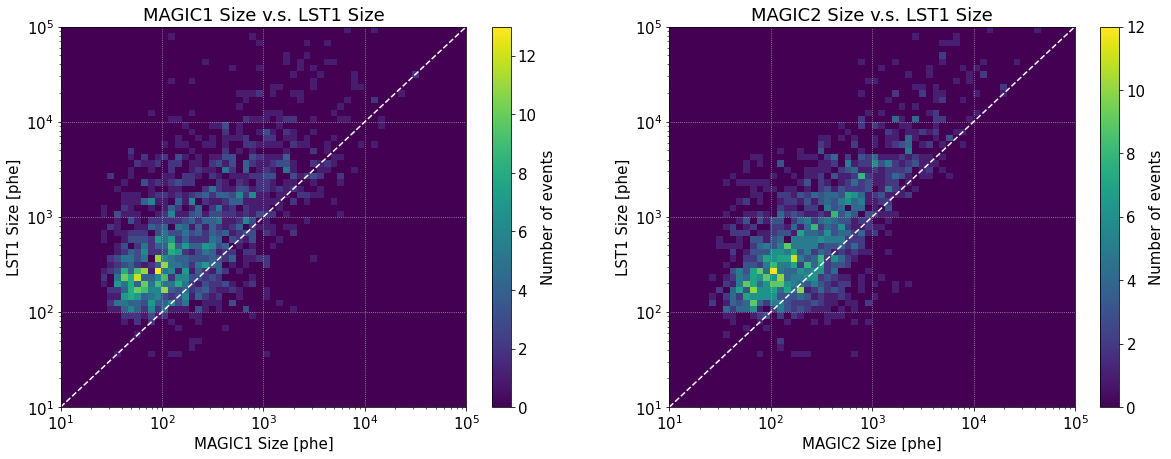

In [38]:
pyplot.figure(figsize=(20, 7))
grid = (1, 2)

for i, tel_id in enumerate([5, 6]):
    pyplot.subplot2grid(grid, (0, i))
    pyplot.title(f'MAGIC{i+1} Size v.s. LST1 Size')
    pyplot.xlabel(f'MAGIC{i+1} Size [phe]')
    pyplot.ylabel('LST1 Size [phe]')
    pyplot.loglog()
    
    df_lst = dl2_data_stereo.query('tel_id == 1')
    df_magic = dl2_data_stereo.query(f'tel_id == {tel_id}')
    
    hist, xedges, yedges = np.histogram2d(df_magic['intensity'].values, df_lst['intensity'].values, bins=np.logspace(1, 5, 61))
    pyplot.pcolormesh(xedges, yedges, hist.transpose(), norm=colors.PowerNorm(gamma=1))

    bar = pyplot.colorbar()
    bar.set_label('Number of events')
    
    pyplot.plot((1e1, 1e5), (1e1, 1e5), color='white', linestyle='--')
    
    pyplot.grid(linestyle=':')